In [31]:
import numpy as np
import scipy.stats as sc
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import time

In [3]:
# ground truth data
ground_truths = np.load('mt_trajectories.npy')
ground_truths

array([[[ -8.07218076,  -4.49125581,  -0.91033086,   2.67059409,
           6.25151904,   9.83244399,  13.41336894,  16.99429389,
          20.57521884,  24.15614379],
        [ -0.8844742 ,  -2.77044353,  -4.65641285,  -6.54238217,
          -8.4283515 , -10.31432082, -12.20029014, -14.08625947,
         -15.97222879, -17.85819811],
        [ -3.88086752,  -2.92152956,  -1.96219159,  -1.00285363,
          -0.04351567,   0.91582229,   1.87516025,   2.83449821,
           3.79383618,   4.75317414]],

       [[ -6.46454434,  -3.36883308,  -0.27312181,   2.82258945,
           5.91830072,   9.01401198,  12.10972325,  15.20543452,
          18.30114578,  21.39685705],
        [  5.1703906 ,   6.05898913,   6.94758765,   7.83618618,
           8.72478471,   9.61338324,  10.50198177,  11.3905803 ,
          12.27917883,  13.16777736],
        [ -1.3581392 ,  -0.35850924,   0.64112072,   1.64075068,
           2.64038064,   3.6400106 ,   4.63964056,   5.63927052,
           6.63890048,   7.6

## Background

### Motion model

In [4]:
# # utility functions
# this is the version for [x, dx, y, dy]
# def create_state_matrix(dt:float= 1.0, dim:int = 2):
#     mat = []
#     for i in range(dim):
#         row = []
#         for j in range(dim):
#             if i == j:
#                 row.append(np.array([[1, dt], [0, 1]]))
#             else:
#                 row.append(np.zeros((2, 2)))
#         mat.append(row)
#     return np.block(mat)

def create_state_matrix(dt:float = 1.0, dim:int = 2):
    return np.vstack((
        np.hstack((np.identity(dim), np.identity(dim) * dt)),
        np.hstack((np.zeros((dim, dim)), np.identity(dim)))
    ))


def create_measurement_matrix(dim:int = 2):
    return np.hstack((np.identity(dim), np.zeros((dim, dim))))

The motion model describes how objects of a system move. Define the motion model as $$x_{k+1} = F \times x_{k} + w_{k}$$ where
\begin{gather*}
    \text{$x_{k+1}$: next state} \\
    \text{$F$: state transition matrix} \\
    \text{$x_{k}$: current state} \\
    \text{$w_{k}$: process noise.} \\
\end{gather*}

Assume motion is constant velocity in 2 dimensions, where state is represented by $[x, y, v_{x}, v_{y}]$ (i.e., x-pos, y-pos, x-vel, y-vel). Then, $F$ is defined by
$$ F = \begin{bmatrix}
    1 & 0 & dt & 0 \\
    0 & 1 & 0 & dt \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
\end{bmatrix}.$$

In [5]:
# dimensions
dim = 2
# timestep (1s)
dt = 1.0
# state transition matrix
F = create_state_matrix(dt, dim)
F

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Assume $w_{k}$ has 0 mean and 0.25 variance. Sampled from a multivariate Gaussian, its covariance $Q$ is defined by
$$ Q = \begin{bmatrix}
    0.25 & 0 & 0 & 0 \\
    0 & 0.25 & 0 & 0 \\
    0 & 0 & 0.25 & 0 \\
    0 & 0 & 0 & 0.25 \\
\end{bmatrix}.$$

In [6]:
# process noise covariance
Q = np.identity(F.shape[0]) * 0.25
Q

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [67]:
def simulate_motion_basic(num_steps:int=10, init_truths:int=3):
    all_states = {}
    # initial truths
    for i in range(init_truths):
        state = np.array([
            *np.random.uniform(-30, 30, 2),
            *np.random.uniform(-2, 2, 2),
        ])

        all_states[i] = [state.copy()]

    for step in range(1, num_steps + 1):
        
        for i in all_states.keys():
            # get previous state
            state = all_states[i][-1]
            
            # # without noise
            # new_state = F @ state
            # with noise
            new_state = F @ state + np.random.multivariate_normal(np.zeros(Q[0].size), Q)
            all_states[i].append(new_state.copy())

    return all_states


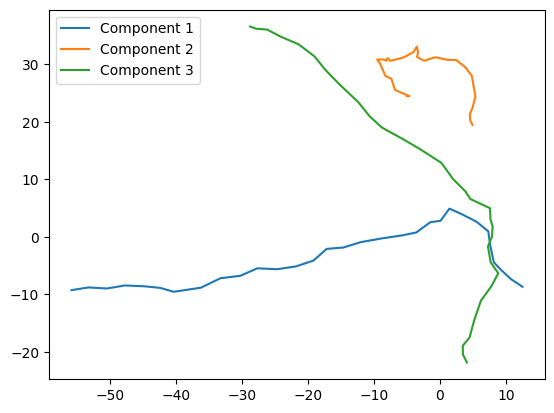

In [68]:
# generate ground truths (i.e., true motion)
# assume 3 components
%matplotlib inline
num_components = 3
ground_truths = simulate_motion_basic(num_steps=30, init_truths=num_components)
for i, state in ground_truths.items():
    pos = np.array([s[:2] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.legend()
plt.show()

Now, assume objects have a specific birth and death probability. Birth refers to the spontaneous introduction of an object into a scene, whereas death refers to the spontaneous removal of an object from a scene.

In [69]:
# generalized form to include birth and death probabilities
def simulate_motion(num_steps:int = 10, init_truths:int = 3, F:np.ndarray=F, Q:np.ndarray=Q, birth_prob:float = 0.2, death_prob:float = 0.05):
    all_states = {}
    # initial truths
    for i in range(init_truths):
        state = np.array([
            *np.random.uniform(-30, 30, 2),
            *np.random.uniform(-2, 2, 2),
        ])

        all_states[i] = [state.copy()]

    next_id = init_truths

    for step in range(1, num_steps + 1):
        
        for i in all_states.keys():
            # get previous state
            state = all_states[i][-1]

            # if dead, stay dead
            if state is None:
                all_states[i].append(None)
                continue

            # death
            if np.random.rand() <= death_prob:
                all_states[i].append(None)
                continue
            
            # # without noise
            # state = F @ state
            # with noise
            new_state = F @ state + np.random.multivariate_normal(np.zeros(Q[0].size), Q)
            all_states[i].append(new_state.copy())

        # birth
        if np.random.rand() <= birth_prob:
            state = np.array([
                *np.random.uniform(-30, 30, 2),
                *np.random.uniform(-2, 2, 2),
            ])
            all_states[next_id] = [None] * step + [state.copy()]
            next_id += 1

    return all_states

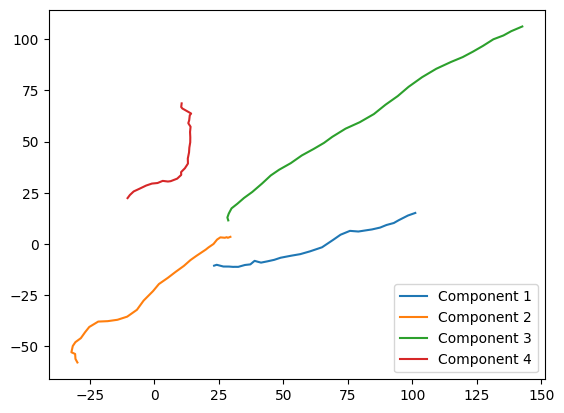

In [81]:
birth_death_truths = simulate_motion(num_steps=30, birth_prob=0.05, death_prob=0.005)
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
plt.legend()

### Measurement model

The measurement model describes what the sensor sees. Define the measurement model as $$ z_{k} = Hx_{k} + v_{k}$$ where
\begin{gather*}
    \text{$z_{k}$: observed measurement} \\
    \text{$H$: measurement matrix} \\
    \text{$v_{k}$: measurement noise.} \\
\end{gather*}

Assume a sensor only measures position. Then, $H$ is defined by
$$ H = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
\end{bmatrix}.$$


In [82]:
# measurement matrix
H = create_measurement_matrix(dim)
H

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]])

Assume $v_{k}$ has 0 mean and 0.75 variance. Its covariance R is defined by
$$ R = \begin{bmatrix}
    0.75 & 0 \\
    0 & 0.75 \\
\end{bmatrix}.$$

In [83]:
# measurement noise covariance
R = np.identity(H.shape[0]) * 0.75
R

array([[0.75, 0.  ],
       [0.  , 0.75]])

Assume the sensors have a certain detection rate. Sensors frequently detect objects that are not targets of interest. These objects are referred to as clutter, which have to be filtered out from predictions.

In [84]:
def simulate_measurement(ground_truths, num_steps:int=10, det_prob:float=0.9, clutter_rate:float=3.0, H:np.ndarray=H, R:np.ndarray=R):
    # all measurements
    all_measurements = {}
    for step in range(num_steps):
        measurements = []
        # real measurement
        for i, states in ground_truths.items():
            # if an item is already dead at the current time step
            if step >= len(states):
                continue

            state = states[step]
            # if an item is dead at the current timestep
            if state is None:
                continue
            
            # detect with detection probability
            if np.random.rand() <= det_prob:
                measurement = H @ state + np.random.multivariate_normal(np.zeros(R[0].size), R)
                measurements.append((i, measurement.copy()))

        # clutter
        for _ in range(np.random.poisson(clutter_rate)):
            clutter = np.array([
                np.random.uniform(-100, 100), 
                np.random.uniform(-100, 100)
            ])
            measurements.append((None, clutter.copy()))
        
        all_measurements[step] = measurements

    return all_measurements


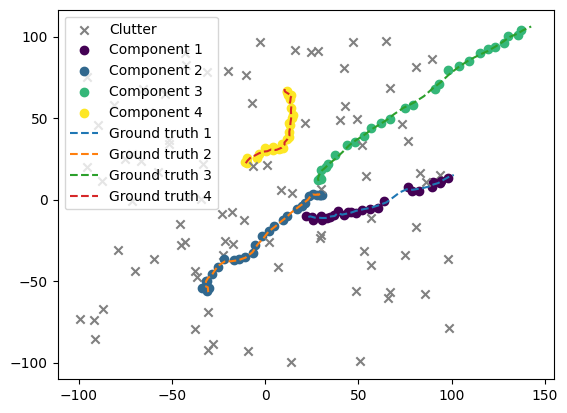

In [102]:
# generate measurements
all_measurements = simulate_measurement(birth_death_truths, num_steps=30)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

# matplotlib.colormaps
cmap = colormaps['viridis']
colors = [cmap(i / max(len(component_ids) - 1, 1)) for i in range(len(component_ids))]
color_map = {comp: colors[idx] for idx, comp in enumerate(sorted(component_ids))}
# color_map = {comp: colors(idx) for idx, comp in enumerate(sorted(component_ids))}


for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='gray', marker='x', label='Clutter')
        else:
            color = color_map[i]
            plt.scatter(measurement[0], measurement[1], color=color, marker='o', label=f'Component {i + 1}')
    
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

## PHD Filter

The PHD filter propagates the first-order stastical moment (mean) of the posterior multiple-target state. 

Suppose, for a multi-target scenario, that the target states at time $k - 1$ are $x_{k-1,1},...,x_{k-1,M(k-1)} \in \mathcal{X}$. For a random finite set (RFS) $X$ on $\mathcal{X}$ with probality distribution $P$, its mean is a nonnegative function $v$ on $\mathcal{X}$ (the intensity)

## GM-PHD Filter

The GM-PHD filter approximates the PHD function with a Gaussian mixture. Each target is treated as a Gaussian component. The PHD is then defined as $$D_{k|k-1}(x) = \sum_{i=1}^{J_{k|k-1}}{w^{i}_{k|k-1}\mathcal{N}(x, m^{i}_{k|k-1},P^{i}_{k|k-1})},$$ where 
\begin{gather*}
    \text{$J_{k|k-1}$: number of components} \\
    \text{$w^{i}_{k|k-1}$: weight of component $i$} \\
    \text{$m^{i}_{k|k-1}$: mean (state vector) of component $i$} \\
    \text{$P^{i}_{k|k-1}$: covariance of component $i$.}\\
\end{gather*}

Assume the targets are linear Gaussian. The birth RFSs of each component are Gaussian mixtures.

In [10]:
# number of components
num_components = 3

# assume each component has the same weight
component_weight = 0.1

# the variance of pos and vel
pos_var = 100
vel_var = 25

# each component starts at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-100, 100)

w = [component_weight] * num_components
m = []
for _ in range(3):
    m.append([np.random.uniform(start_bounds[0], start_bounds[1]), 0, np.random.uniform(start_bounds[0], start_bounds[1]), 0])
m = np.array(m)
P = np.diag([pos_var, vel_var, pos_var, vel_var])

print(w)
print(m)
print(P)

"""
(ID, location)
"""

[0.1, 0.1, 0.1]
[[ -0.23675887   0.          16.26335313   0.        ]
 [  7.22491694   0.          42.28445286   0.        ]
 [-65.57234457   0.         -49.06708268   0.        ]]
[[100   0   0   0]
 [  0  25   0   0]
 [  0   0 100   0]
 [  0   0   0  25]]


'\n(ID, location)\n'